In [20]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)

# Load 30,000 rows from Kaggle dataset
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv', nrows=100000)

# Preview the data
print("Shape:", df.shape)
df.head()


Shape: (100000, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [21]:
# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Fill missing categorical values (future-proof: no inplace)
df['category_code'] = df['category_code'].fillna('unknown')
df['brand'] = df['brand'].fillna('unknown')

# Create a binary flag for purchase
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)

# Check for nulls again to confirm
print("Missing values after cleaning:\n", df.isnull().sum())


Missing values after cleaning:
 event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
is_purchase      0
dtype: int64


In [25]:
# Get sets of unique users at each funnel stage
view_users = set(df[df['event_type'] == 'view']['user_id'])
cart_users = set(df[df['event_type'] == 'cart']['user_id'])
purchase_users = set(df[df['event_type'] == 'purchase']['user_id'])

# Funnel conversion rates
visit_to_cart = len(cart_users) / len(view_users) * 100
cart_to_purchase = len(cart_users & purchase_users) / len(cart_users) * 100
visit_to_purchase = len(purchase_users) / len(view_users) * 100

print(f"Visit to Cart Conversion Rate: {visit_to_cart:.2f}%")
print(f"Cart to Purchase Conversion Rate: {cart_to_purchase:.2f}%")
print(f"Overall Visit to Purchase Conversion Rate: {visit_to_purchase:.2f}%")


Visit to Cart Conversion Rate: 3.30%
Cart to Purchase Conversion Rate: 52.55%
Overall Visit to Purchase Conversion Rate: 5.58%


In [34]:
# Aggregate user-level metrics
user_features = df.groupby('user_id').agg({
    'event_type': 'count',       # total events by user
    'is_purchase': 'sum',        # number of purchases
    'price': 'mean',             # avg price seen by user
    'event_time': ['min', 'max'] # first & last interaction
})

# Flatten multi-index columns
user_features.columns = ['total_events', 'total_purchases', 'avg_price', 'first_event', 'last_event']

# Calculate active days
user_features['active_days'] = (user_features['last_event'] - user_features['first_event']).dt.days + 1

# Reset index to make 'user_id' a column again
user_features = user_features.reset_index()

# Preview
user_features.head()


,user_id,total_events,total_purchases,avg_price,first_event,last_event,active_days
0,275256741,1,0,1415.480000,2019-11-01 02:23:03+00:00,2019-11-01 02:23:03+00:00,1
1,295643776,8,0,189.946250,2019-11-01 03:12:38+00:00,2019-11-01 03:15:53+00:00,1
2,356520186,6,1,33.450000,2019-11-01 03:39:27+00:00,2019-11-01 03:49:22+00:00,1
3,389979783,4,0,431.410000,2019-11-01 01:43:56+00:00,2019-11-01 01:44:47+00:00,1
4,394300322,11,0,120.418182,2019-11-01 03:03:24+00:00,2019-11-01 03:24:03+00:00,1


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


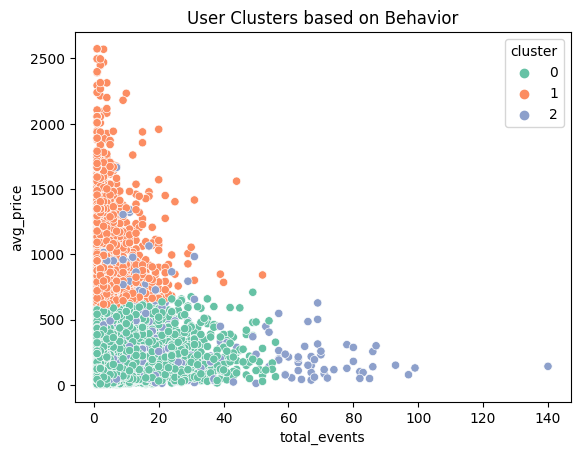

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features for clustering
X = user_features[['total_events', 'total_purchases', 'avg_price', 'active_days']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans (you can try different n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
user_features['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using 2D plot (optional)
sns.scatterplot(data=user_features, x='total_events', y='avg_price', hue='cluster', palette='Set2')
plt.title("User Clusters based on Behavior")
plt.show()


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Target: whether user made any purchase
user_features['label'] = (user_features['total_purchases'] > 0).astype(int)

# Features to train on
X = user_features[['total_events', 'avg_price', 'active_days']]
y = user_features['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction & evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3918
           1       0.14      0.11      0.12       238

    accuracy                           0.91      4156
   macro avg       0.54      0.53      0.54      4156
weighted avg       0.90      0.91      0.91      4156



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


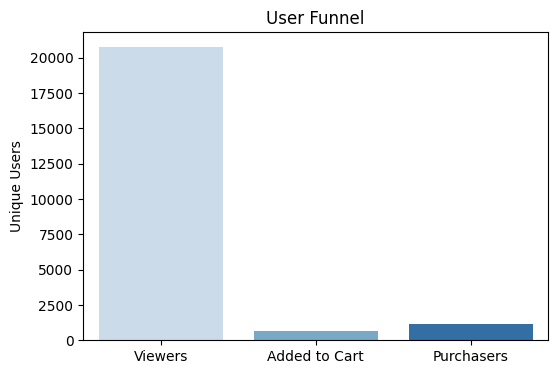

In [38]:
import matplotlib.pyplot as plt

# Funnel plot
stages = ['Viewers', 'Added to Cart', 'Purchasers']
counts = [len(view_users), len(cart_users), len(purchase_users)]

plt.figure(figsize=(6, 4))
sns.barplot(x=stages, y=counts, palette='Blues')
plt.title('User Funnel')
plt.ylabel('Unique Users')
plt.show()
